**Jianwei Hu**
# Bandit Problems Homework

Cited from the Andre Cianflone's Thompson sampling notebook, we created the class necessary for the bandit problems experiment.

In [10]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

In [11]:
# adapted from Andre Cianflone's Thompson sampling notebook
stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

In [12]:
# adapted from Andre Cianflone's Thompson sampling notebook
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

In [13]:
# adapted from Andre Cianflone's Thompson sampling notebook
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 
  

In [14]:
# adapted from Andre Cianflone's Thompson sampling notebook
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

Random class will choose the arm randomly and serves as an control in this experiment.

In [15]:
class Random():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
  
  @staticmethod 
  def name():
    return 'random'
  
  def get_action(self):
    return np.random.randint(0, self.arm_count)
  
  def get_reward_regret(self, arm):
    return self.bandit.get_reward_regret(arm)

In [16]:
# adapted from Andre Cianflone's Thompson sampling notebook
# modified

def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000, algos = [EpsilonGreedy, UCB, BernThompson, Random]):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

# Answer the following questions 

1. Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points) 

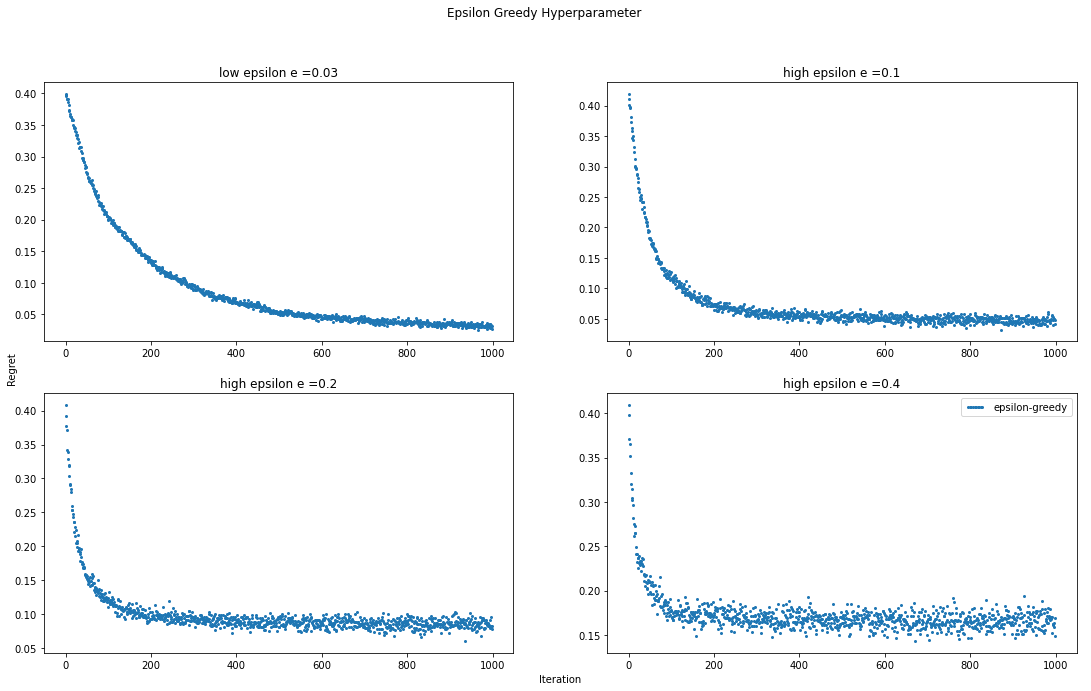

In [108]:
arm_count = 10
stationary=True

fig, axes = plt.subplots(sharex=False,sharey=True)

plt.subplot(2, 2, 1)
epsilon = 0.03
experiment(arm_count, algos = [EpsilonGreedy])
plt.title("e =" + str(epsilon))

plt.subplot(2, 2, 2)
epsilon = 0.1
experiment(arm_count, algos = [EpsilonGreedy])
plt.title("e =" + str(epsilon))

plt.subplot(2, 2, 3)
epsilon = 0.2
experiment(arm_count, algos = [EpsilonGreedy])
plt.title("e =" + str(epsilon))

plt.subplot(2, 2, 4)
epsilon = 0.4
experiment(arm_count, algos = [EpsilonGreedy])
plt.title("e =" + str(epsilon))


plt.suptitle('Epsilon Greedy Hyperparameter')
plt.legend(loc='upper right', prop={'size': 10}, numpoints=10)

fig.add_subplot(111, frame_on=False)
fig.set_size_inches(18.5, 10.5)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Regret')
plt.xlabel('Iteration')
plt.show()

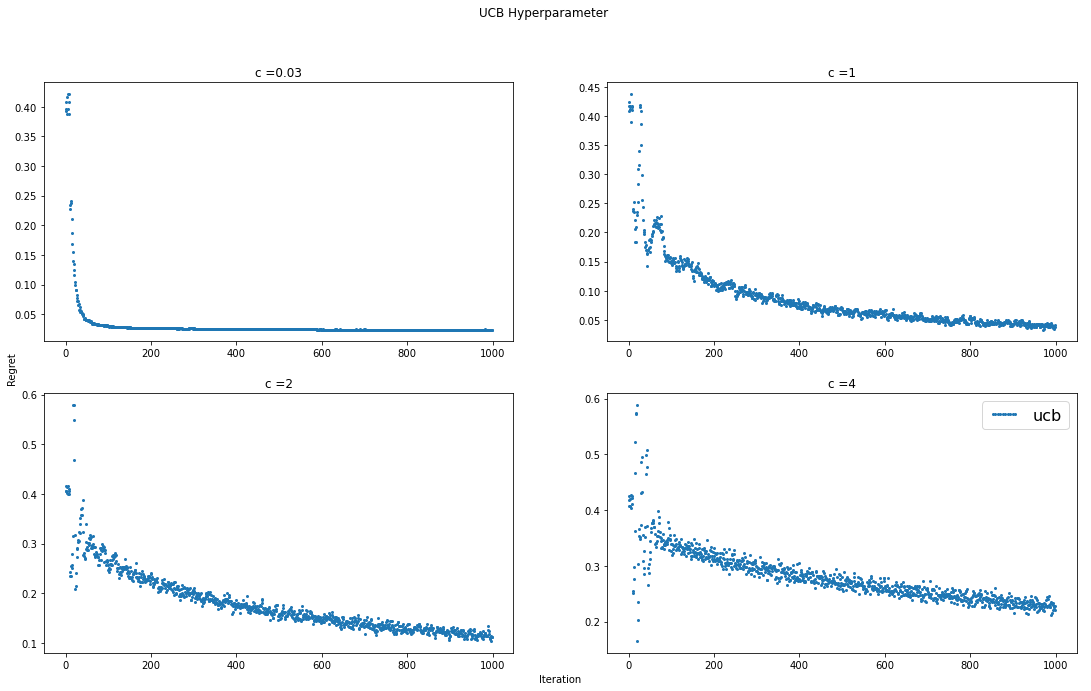

In [32]:
arm_count = 10
stationary=True

fig, axes = plt.subplots(sharex=True,sharey=True)

plt.subplot(2, 2, 1)
ucb_c = 0.03
experiment(arm_count, algos = [UCB])
plt.title("c =" + str(ucb_c))

plt.subplot(2, 2, 2)

ucb_c = 1
experiment(arm_count, algos = [UCB])
plt.title("c =" + str(ucb_c))

plt.subplot(2, 2, 3)
ucb_c = 2
experiment(arm_count, algos = [UCB])
plt.title("c =" + str(ucb_c))

plt.subplot(2, 2, 4)

ucb_c = 4
experiment(arm_count, algos = [UCB])
plt.title("c =" + str(ucb_c))

plt.suptitle('UCB Hyperparameter')
plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)

fig.add_subplot(111, frame_on=False)
fig.set_size_inches(18.5, 10.5)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Regret')
plt.xlabel('Iteration')
plt.show()

Random sampling has no hyperparameter. e-greedy has epsilon as the hyperparameter to control the possibility of iteration being explorative or exploitative. It also has N and Q for remembering number of time arm being selected and success over number of time arm being selected. UCB also has the hyperparameter c for fine tuning the explorativity of the algorithm. When c is high, it tends to explore and when c is low, it is more exploitative. Like e-greedy, it also has N and Q for previous selection. Thompson has two important parameter, alpha as the number of success and beta as the number of failure. It will use both parameter to sample possibility of selecting the arm through beta distribution.

2. How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

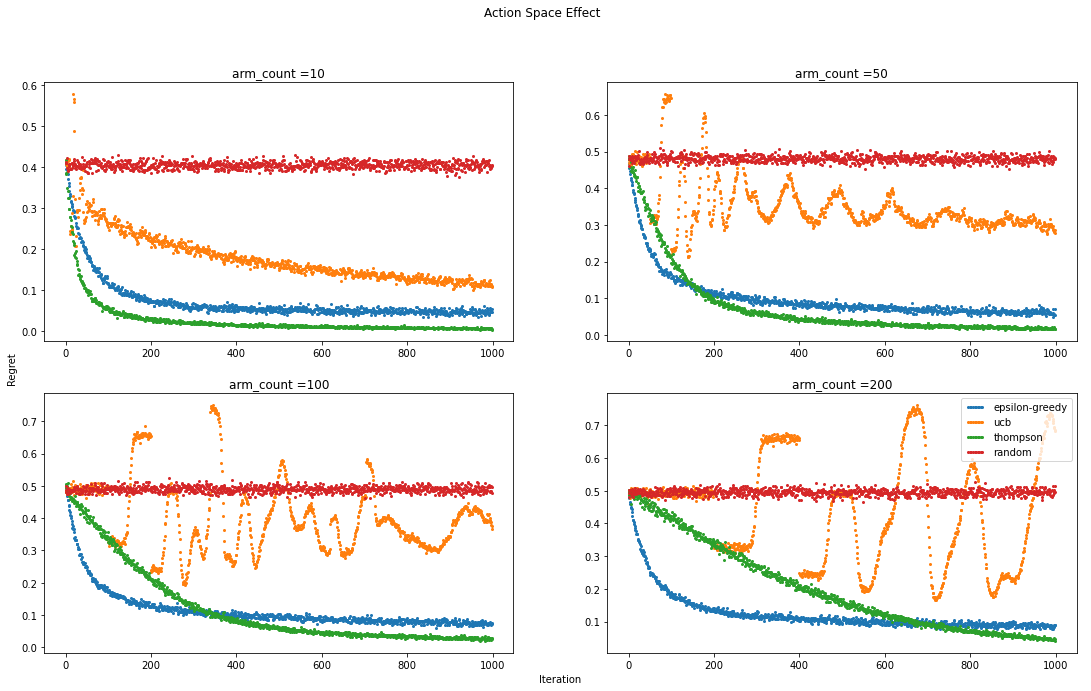

In [8]:
stationary=True
epsilon = 0.1
ucb_c = 2

fig, axes = plt.subplots(sharex=False,sharey=True)

plt.subplot(2, 2, 1)
arm_count = 10
experiment(arm_count)
plt.title("arm_count =" + str(arm_count))

plt.subplot(2, 2, 2)
arm_count = 50
experiment(arm_count)
plt.title("arm_count =" + str(arm_count))

plt.subplot(2, 2, 3)
arm_count = 100
experiment(arm_count)
plt.title("arm_count =" + str(arm_count))

plt.subplot(2, 2, 4)
arm_count = 200
experiment(arm_count)
plt.title("arm_count =" + str(arm_count))


plt.suptitle('Action Space Effect ')
plt.legend(loc='upper right', prop={'size': 10}, numpoints=10)

fig.add_subplot(111, frame_on=False)
fig.set_size_inches(18.5, 10.5)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Regret')
plt.xlabel('Iteration')
plt.show()

As the graph shows in four different size of action space, we can see that the action space's influence on different approaches. 

For random sampling, as the action space increases, the regret converge to 0.5. Since we use uniform distribution between 0 and 1 for the thetas generating. The average of the theta will roughly equals to 0.5 through different experiment. As the action space increases, it is more likely to generate the theta that equals to 1 and thus the regret increases and approaches to 0.5 which is the max theta minus average of thetas.

For Thompson sampling, as the action space increases, the iteration it needs to converge to zero regret increases. That is because as the action space getting larger, it needs more iteration for the algorithm to explore and find the best choice.

UCB tends to diverge when the action space gets too large, that is because when action space is too big, each arm will have roughly the same value for the selection. This can be fixed by lowering the c value.

e-greedy method behaves stable as the action space increases, this is because the probablity for the algorithm to explore is preset and will not affect by the action space. In the graph it show as the action space increases, the elbow point is getting higher and higher. The algorithm converges at the suboptimal choice and it takes more iterations to find the optimal choice.

3. How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

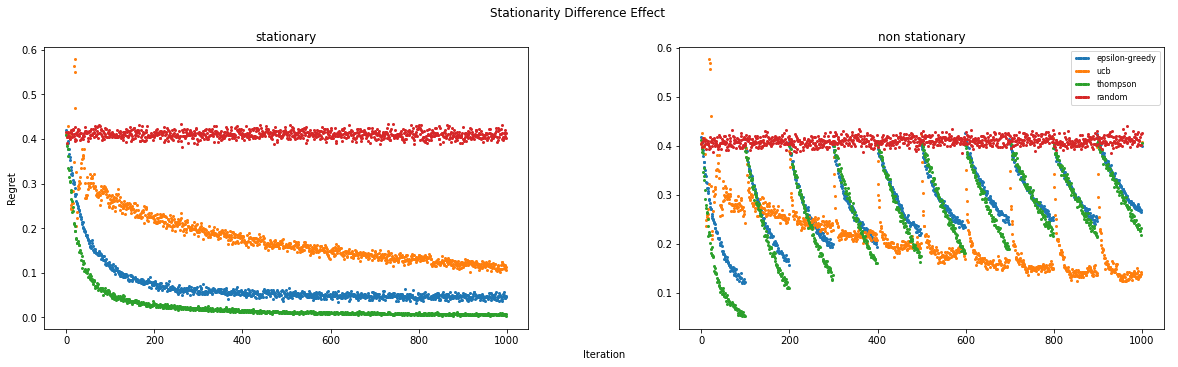

In [109]:
arm_count = 10
epsilon = 0.1
ucb_c = 2

fig, axes = plt.subplots(sharey=True)
plt.subplot(1, 2, 1)
plt.title('stationary')

#stationary experiment
stationary=True
experiment(arm_count)

plt.subplot(1, 2, 2)
plt.title('non stationary')

#non-stationary experiment
stationary=False
experiment(arm_count)

plt.suptitle('Stationarity Difference Effect')
plt.legend(loc='upper right', prop={'size': 8}, numpoints=10)

fig.add_subplot(111, frame_on=False)
fig.set_size_inches(18.5, 5.25)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Regret')
plt.xlabel('Iteration')
plt.show()

Graph above shows the different methods under stationary and non stationary situation. It has little effect to the random sampling as the method is just randomly choosing one the arm. For the rest methods, we can see the regret increases every time the system resampling the thetas. The UCB, however, has a trend of continuous lowering the regret, this might because the c value was set too high and emphasize too much on exploring. It can be fixed by lowering c value as mentioned in Andre Cianflone's notebook.

4. When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff (15 Points) 

e-greedy will not stop exploring as its rate of exploration is preset as epsilon. Thompson and UBC will lower the exploration rate as they are more certain about the optimal choice through iterations. At the specific iteration when optimal arm reaches highest action value that cannot be surpassed by other arms, we can say that the exploration is over. Random sampling has no exploration phase.

If exploration is high, the algorithm will consume less iteration to find the optimal choice. However, it will risk having the bad choice and waste iterations if we already have the optimal choice. On the other hand if we set the exploitation high, we will always choose the best choice in hand and it might be way longer for the algorithm the reach the optimal choice. It is up to the specific question to determine whether we need to increase or decrease the portion of exploration.

5. How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. (10 Points) 


Thompson Sampling remebers through alpha and beta, which are number of success and number of failure. e-greedy and UBC using N and Q. N is number of choice being chosen and Q is fraction of number of success over N. Random sampling doesn't remeber anything. 

6. Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)

In [27]:
# adapted from Andre Cianflone's Thompson sampling notebook
# modified for Thompson using normal distribution
class NormalThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'normal-thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the normal distribution"""
    sum = self.alpha + self.beta
    # alpha over number of selection as myu and 1 over number of selection as sigma
    theta = np.random.normal(self.alpha / sum, 1 / sum)
    return theta.argmax()

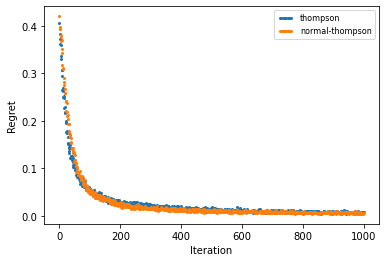

In [36]:
stationary=True
experiment(arm_count,1000, algos = [BernThompson, NormalThompson])
plt.legend(loc='upper right', prop={'size': 8}, numpoints=10)
plt.ylabel('Regret')
plt.xlabel('Iteration')
plt.show()

## References
Cianflone, A. (n.d.). Google Colaboratory. Retrieved September 28, 2020, from https://colab.research.google.com/drive/1BHVH712x2Q2As9E5nN5Y8UR74T8w6AMO

MIT License

Copyright (c) 2020 Jianwei Hu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.